### **Importing required packages:**

In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

import pygsm
from pygsm import GlobalSkyModel

import ephem
from astropy.time import Time
from astropy.coordinates import Galactic, SkyCoord, FK5, EarthLocation, AltAz, Angle
import astropy.units as u

import pandas as pd
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline

### **Defining some constants:**

In [2]:
h = 6.62607157e-34
k = 1.3806488e-23
c = 2.99792458e+08
TCMB = 2.72548


### **Sky Model part code below:** 

In [3]:
NPIX = hp.nside2npix(16)
T = np.empty(NPIX)

gsm = GlobalSkyModel(freq_unit='GHz')

#**Generating maps for frequencies from 2 to 4 GHz in increment of 100MHz:**

freqs = np.linspace(2,4, 21)
CMB_Int = np.empty(21)
P_hot = np.empty(21)
P_cold = np.empty(21)
P_dif = np.empty(21)
spectrum = gsm.generate(freqs)

#Decreasing the resolution to NSIDE = 16

spec = hp.pixelfunc.ud_grade(spectrum,16)
df = pd.DataFrame(spec)
df = df.transpose()
df.columns = np.arange(2,4.1,0.1)
df = df*1e-20
#Basically 1e-20 factor is to convert MJy/Sr (PyGSM pack has this units) to W/m^2 Hz (SI units)



#Calculation of CMB intensity below for each frequencies

i=0
while i<21:
    #Calculation of CMB intensities at different frequencies below
    CMB_Int[i] = (2*h*math.pow(df.columns[i]*1e9,3.0)/(c*c*math.exp(h*df.columns[i]*1e9/k*TCMB)-1))
    #P_hot and P_cold calculation for calibration below
    P_hot[i] = (df.columns[i]*373)   #Dummy function. Have to look the function
    P_cold[i] = (df.columns[i]*273)    #Dummy function. Haven't looked the function still
    P_dif[i] = P_hot[i] - P_cold[i]      #Dummy... its obvious now!
    
    i=i+1
    

CMB = pd.DataFrame(CMB_Int)
CMB = CMB.transpose()
CMB.columns = np.arange(2,4.1,0.1)
CMB = CMB.transpose()
df = df.transpose()

CMB_plus_Gal = np.add(df, CMB.to_numpy())    #Adding CMB and Galactic contribution intensities in SI units. Recombination line intensity is added later.
print(CMB_plus_Gal)
print(P_dif)







             0             1             2             3             4     \
2.0  2.044495e-21  1.853518e-21  1.942720e-21  1.998804e-21  2.154175e-21   
2.1  1.772078e-21  1.608339e-21  1.685826e-21  1.734436e-21  1.866421e-21   
2.2  1.555249e-21  1.413678e-21  1.481421e-21  1.523838e-21  1.637062e-21   
2.3  1.382578e-21  1.259162e-21  1.318735e-21  1.355981e-21  1.454089e-21   
2.4  1.244181e-21  1.135799e-21  1.188470e-21  1.221362e-21  1.307129e-21   
2.5  1.131128e-21  1.035444e-21  1.082248e-21  1.111444e-21  1.186831e-21   
2.6  1.038786e-21  9.539066e-22  9.956901e-22  1.021726e-21  1.088315e-21   
2.7  9.636293e-22  8.880002e-22  9.254624e-22  9.487813e-22  1.007864e-21   
2.8  9.028669e-22  8.352025e-22  8.689241e-22  8.898930e-22  9.425363e-22   
2.9  8.542694e-22  7.934992e-22  8.239660e-22  8.428920e-22  8.899805e-22   
3.0  8.160415e-22  7.612684e-22  7.888896e-22  8.060310e-22  8.483039e-22   
3.1  7.867266e-22  7.371942e-22  7.623162e-22  7.778918e-22  8.159703e-22   

### **LST calculation and Coordinate transform:**

In [4]:
#Sidereal time calculation

Obs = ephem.Observer()
t = Time('2022-05-09 16:15:00.0000', scale='utc',location=('10', '0'))
lst = t.sidereal_time('apparent')
print(lst)


#Checking the number of pixels

NPIX = hp.nside2npix(16)
print(NPIX)

i=1
alt = np.empty(NPIX)
az = np.empty(NPIX)

#For every pixel, get the horizontal coordinate. 

while i<NPIX:
    coords = hp.pixelfunc.pix2ang(16, i , nest = False, lonlat = True)
    gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
    
    equi = gc.transform_to(AltAz(obstime = '2022-06-08T11:10:10.10', location = EarthLocation(lat = 12.9716*u.deg, lon=77.5946*u.deg, height=900*u.m)))
    
    #Getting the magnitude of azimuthal value alone in deg
    az[i-1]= equi.az .value 
    
    #Getting the magnitude of altitude value alone in deg
    alt[i-1] = equi.alt .value 
    
    i=i+1

print(az) #List of az for each pixel as an array
print(alt) #List of alt for each pixel as an array


8h04m49.48176101s
3072
[6.16171970e+001 6.58797488e+001 6.92308200e+001 ... 2.45044232e+002
 2.41621672e+002 1.40051722e-312]
[ 4.05126470e+001  4.31621157e+001  3.98745462e+001 ... -3.73540173e+001
 -4.05179033e+001  1.40051722e-312]


### **Recombination data: Intensity vs frequency**

        Frequency     Intensity
0        0.009984  1.255914e-32
1        0.010003  1.258055e-32
2        0.010022  1.260196e-32
3        0.010041  1.262337e-32
4        0.010061  1.264478e-32
...           ...           ...
6835  4966.790300  2.870275e-33
6836  4976.331500  2.601257e-33
6837  4985.890900  2.353869e-33
6838  4995.468700  2.126862e-33
6839  5005.064900  1.918862e-33

[6840 rows x 2 columns]


/tmp/ipykernel_8511/1268645641.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(r'/home/dhashin/Downloads/total_spec_new.txt',sep= "    " ,header = None)


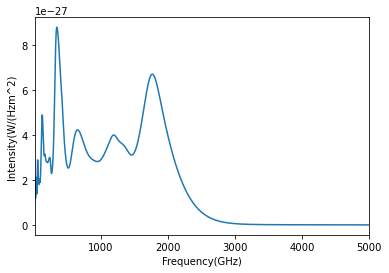

               0
0   5.378384e-28
1   5.392347e-28
2   5.624485e-28
3   6.084408e-28
4   6.258450e-28
5   6.132904e-28
6   6.079663e-28
7   6.083773e-28
8   6.257772e-28
9   6.588920e-28
10  6.910450e-28
11  7.060702e-28
12  7.000464e-28
13  6.879190e-28
14  6.822143e-28
15  6.853704e-28
16  6.991533e-28
17  7.224277e-28
18  7.520901e-28
19  7.824348e-28
20  8.102700e-28
             0             1             2             3             4     \
2.0  2.044496e-21  1.853518e-21  1.942720e-21  1.998805e-21  2.154176e-21   
2.1  1.772079e-21  1.608339e-21  1.685827e-21  1.734437e-21  1.866421e-21   
2.2  1.555249e-21  1.413678e-21  1.481422e-21  1.523839e-21  1.637062e-21   
2.3  1.382579e-21  1.259163e-21  1.318736e-21  1.355981e-21  1.454089e-21   
2.4  1.244182e-21  1.135800e-21  1.188471e-21  1.221363e-21  1.307130e-21   
2.5  1.131129e-21  1.035445e-21  1.082248e-21  1.111444e-21  1.186832e-21   
2.6  1.038786e-21  9.539072e-22  9.956908e-22  1.021727e-21  1.088316e-21   
2.7  9.636

/tmp/ipykernel_8511/1268645641.py:32: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  T_sky = 100* np.divide(Total_sky,P_dif)   #100K is the difference of T_hot and T_cold.


In [5]:
df = pd.read_csv(r'/home/dhashin/Downloads/total_spec_new.txt',sep= "    " ,header = None)


df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]
print(df)

#ploting graph of intensity vs frequency

plt.plot(df["Frequency"],df["Intensity"])
plt.xlim(10,5000)
plt.xlabel('Frequency(GHz)')
plt.ylabel('Intensity(W/(Hzm^2)')

plt.show()

x = df["Frequency"]
y= df["Intensity"]

ius = InterpolatedUnivariateSpline(x, y)

y = ius(np.arange(2,4.1,0.1))
Rec_spec = pd.DataFrame(y)
print(Rec_spec)     #Getting intensities at the required frequencies

Total_sky = np.add(CMB_plus_Gal, Rec_spec.to_numpy())     #Adding reco. signal with gala. signal and CMB (All in SI units)
print(Total_sky)

P_dif = pd.DataFrame(P_dif)
print(P_dif)

T_sky = 100* np.divide(Total_sky,P_dif)   #100K is the difference of T_hot and T_cold. 
print(T_sky)




### **Function to generate map of visible sky given the location and time:**

In [6]:
NPIX = hp.nside2npix(16)
print(NPIX)

gsm = GlobalSkyModel(freq_unit='GHz')


def Visible_Sky(frequency, latitude, longitude, altitude, T):           #Here frequency is taken in GHz, lat and lon in degrees and T is the format 'YYYY-MM-DD HH:MM:SS.SS'
    spectrum = gsm.generate(frequency)
    spectrum = hp.pixelfunc.ud_grade(spectrum, 16)                      #Reducing the resolution to NSIDE=16

    i=1

    while i<NPIX:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = False, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc.transform_to(AltAz(obstime = T, location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m)))
        
        #If alt<0 in horizontal coordinates, that is not visible for the observer. So, suxh pixels are given minimum value (grey in map)
        if (equi.alt<0):
            spectrum[i-1] = -1.6375e+30
    
        i = i+1  
    print(spectrum)
    
spectrum_value = Visible_Sky(2,10,10,200,'2022-05-15 12:00:00')
print(spectrum_value)


3072
[-1.63750000e+30 -1.63750000e+30 -1.63750000e+30 ...  2.09467862e-01
  2.01622466e-01  1.92877833e-01]
None


In [7]:
#Changing intensity to temperature scale

# for cols in df:
#     df[cols] = df[cols].apply(lambda x:(h* df.columns*1e9)/(k) * (0.5 + (x*1.25664e-20*c*c/(2*h*df.columns*df.columns*df.columns*1e27))))


### **Calculating az, alt for each pixels and adding refraction correction:**

In [14]:
latitude = 12.9716
longitude = 77.5946
altitude = 900
T = '2022-05-22 12:00:00.00'

def refraction(a, b):
    return 1         #Dummy function just to check for errors

i=1
while i<NPIX:           #Working on each pixel
    coords = hp.pixelfunc.pix2ang(16, i , nest = False, lonlat = True)          #Gives l and b coordinates for each pixel
    gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
    equi = gc.transform_to(AltAz(obstime = T, location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m)))
    alt = refraction(equi.alt, altitude)
    
    print(alt)
    i=i+1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
